In [20]:
import importlib
import data_preprocessing, midi_conversion, model_helpers, models

importlib.reload(data_preprocessing)
importlib.reload(midi_conversion)
importlib.reload(model_helpers)
importlib.reload(models)


<module 'models' from 'd:\\classical-music-generation-model\\models.py'>

In [3]:
from data_preprocessing import get_midis_by_composer, midi_objs_to_images_with_metadata

DATA_DIR = "data/midi_image_exports"
MODEL_SAVE_DIR = "models/diffusion_12000"

composers = ["mozart", "haydn", "beethoven"]
midis = get_midis_by_composer(composers)

train_midis, val_midis, test_midis = midis

# Convert all train MIDIs to images
train_midi_objs = [(m, c) for (m, c) in train_midis]
midi_objs_to_images_with_metadata(train_midi_objs, DATA_DIR, "train")

# Repeat process for validation and testing images
val_midi_objs = [(m, c) for (m, c) in val_midis]
midi_objs_to_images_with_metadata(val_midi_objs, DATA_DIR, "val")

test_midi_objs = [(m, c) for (m, c) in test_midis]
midi_objs_to_images_with_metadata(test_midi_objs, DATA_DIR, "test")

Now loading MIDIs from data\train.
Could not load data\train\beethoven-anhang_14_3.mid: Could not decode key with 3 flats and mode 255
Could not load data\train\mozart-piano_sonatas-nueva_carpeta-k281_piano_sonata_n03_3mov.mid: Could not decode key with 2 flats and mode 2
Could not load data\train\unknown_artist-i_o-mozart_k550.mid: MThd not found. Probably not a MIDI file
Loaded 500 MIDI files from data\train
Now loading MIDIs from data\val.
Loaded 47 MIDI files from data\val
Now loading MIDIs from data\test.
Could not load data\test\unknown_artist-i_o-mozart_q1_2.mid: MThd not found. Probably not a MIDI file
Loaded 43 MIDI files from data\test
590 MIDI files retrieved.


In [ ]:
from data_preprocessing import PianoRollDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from models import SimpleUNet, train_diffusion_with_early_stopping
import torch

# UNCONDITIONED DIFFUSION MODEL

train_dataset = PianoRollDataset(f"{DATA_DIR}/train")
val_dataset = PianoRollDataset(f"{DATA_DIR}/val")

N = 20000
perm_train = torch.randperm(len(train_dataset))[:N]
subset_train = Subset(train_dataset, perm_train.tolist())
print(f"Reduced to {len(subset_train)} random images.")

train_loader = DataLoader(subset_train, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False)

T = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SimpleUNet().to(device)

losses = train_diffusion_with_early_stopping(model, train_loader, val_loader, T, num_epochs=200, lr=1e-4, gen_freq=10,
                                             device=device, save_dir="models\diffusion_12000", weight_decay=1e-4, patience=5,
                                             save_checkpoints=True, alpha_start=0.5, alpha_end=0.25)

Found 13994 images in generated/train_images_taller
Found 1336 images in generated/val_images_taller
Reduced to 12000 random images.
cuda

Training for 200 epochs. Validation & checkpoint every 10 epochs.
Early Stopping Patience: 5 checks (≈50 epochs).


Block 1/20:  70%|███████   | 7/10 [02:52<01:13, 24.39s/it, loss=0.0423]

In [15]:
from data_preprocessing import PianoRollDatasetWithMetadata
from torch.utils.data import DataLoader, Subset
import torch
import util

# CONDITIONED WITH CLASSIFIER-FREE GUIDANCE

# Define Mappings
COMPOSER_MAP = {
    "haydn": 0,
    "mozart": 1,
    "beethoven": 2,
    "null": 3
}
KEY_MAP = {
    "C": 0, "Cm": 1, "Db": 2, "C#m": 3, "D": 4, "Dm": 5,
    "Eb": 6, "Ebm": 7, "E": 8, "Em": 9, "F": 10, "Fm": 11, "Gb": 12,
    "F#m": 13, "G": 14, "Gm": 15, "Ab": 16, "G#m": 17, "A": 18,
    "Am": 19, "Bb": 20, "Bbm": 21, "B": 22, "Bm": 23, "Unknown": 24, "null": 25 # NULL token
}

device = util.get_best_device()
print(f"Using device: {device}")

# Load datasets
train_dataset = PianoRollDatasetWithMetadata(f"{DATA_DIR}/train", COMPOSER_MAP, KEY_MAP)
val_dataset = PianoRollDatasetWithMetadata(f"{DATA_DIR}/val", COMPOSER_MAP, KEY_MAP)

# N = 20,000 random IMAGES in training subset
N = 20000
if len(train_dataset) > N:
    perm_train = torch.randperm(len(train_dataset))[:N]
    train_dataset = Subset(train_dataset, perm_train.tolist())

batch_size = 28
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Reduced to {len(train_loader)*batch_size} random images.")

Using device: cuda
Found 26004 images in data/midi_image_exports/train
Found 2469 images in data/midi_image_exports/val
Reduced to 20020 random images.



Training for 200 epochs. Validation & checkpoint every 10 epochs.
Early Stopping Patience: 4 checks (≈40 epochs).


Block 1/20: 100%|██████████| 10/10 [07:23<00:00, 44.33s/it, loss=0.0233]



Epoch 10: Train Loss=0.0233, Val Loss=0.0251


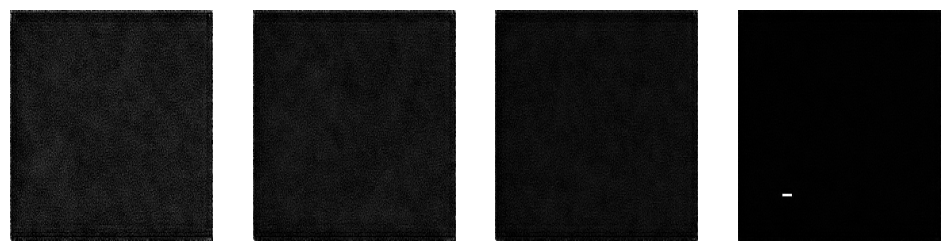

Saved checkpoint to models/diffusion_conditional_12000\diffusion_epoch_0010.pt
New best model, saved to models/diffusion_conditional_12000\best_model.pt


Block 2/20:  10%|█         | 1/10 [00:45<06:45, 45.10s/it, loss=0.0214]

In [ ]:
from models import ConditionedUNet, train_cfg_diffusion_with_early_stopping

# Initialize the model
model = ConditionedUNet(
    channels=[16, 32, 64, 128],
    num_composers=len(COMPOSER_MAP),
    num_keys=len(KEY_MAP)
).to(device)

# Train
# Note: num_composers and num_keys must match the len() of your maps
losses = train_cfg_diffusion_with_early_stopping(
    model, 
    train_loader, 
    val_loader, 
    timesteps=100, 
    num_composers=len(COMPOSER_MAP),
    num_keys=len(KEY_MAP),
    num_epochs=200, 
    lr=1e-4, 
    device=device,
    save_dir="models/diffusion_conditional_12000",
    alpha_start=0.0, 
    alpha_end=0.0
)